# Multi modal model

In [ ]:
%pip install yfinance
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install wordcloud
%pip install torchvision
%pip install -U scikit-learn scipy matplotlib
%pip install pytorch-lightning
%pip install transformers

In [152]:
import yfinance as yf
import numpy as np
import pandas as pd
import glob
import re
import nltk
import nest_asyncio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from calendar import monthrange
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pickle
from datetime import datetime, timedelta, date
import pytz
import torch
import torch.nn as nn
import torch.utils.data as td
import sklearn
import pytorch_lightning as pl
from typing import List, Optional

from joblib import Parallel, delayed
import joblib
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
nltk.download('words')
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score

import torch

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Computing\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Fetch financial record from 1st January 2015 - 31st May 2021

In [154]:
start_date ='2014-12-31'
end_date = '2021-05-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


# Compute Lagged price

In [155]:
price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100


In [156]:
price = price.reset_index()

In [157]:
# Due to the high volatility nature of crypto currency we chose a 1 day lag
lag = 1  # Number of lags
price['Close Lagged Price'] = price['Close'].shift(lag)

In [158]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price
0,2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900,NaN
1,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,320.192993
2,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,314.248993
3,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,315.032013
4,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,281.082001


In [159]:
price.shape

(2343, 8)

In [160]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2343 non-null   datetime64[ns]
 1   Open                2343 non-null   float64       
 2   High                2343 non-null   float64       
 3   Low                 2343 non-null   float64       
 4   Close               2343 non-null   float64       
 5   Adj Close           2343 non-null   float64       
 6   Volume              2343 non-null   int64         
 7   Close Lagged Price  2342 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 146.6 KB


In [161]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price
0,2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900,NaN
1,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,320.192993
2,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,314.248993
3,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,315.032013
4,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,281.082001


# Compute moving average

In [162]:
# We will compute 7, 14, 21 simple moving average moving average 

price['sma7'] = price['Close'].rolling(window=7).mean()
price['sma14'] = price['Close'].rolling(window=14).mean()
price['sma21'] = price['Close'].rolling(window=21).mean()


price['ema12'] = price['Close'].ewm(span=12, adjust=False).mean()
price['ema26'] = price['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
price['MACD line'] = price['ema12'] - price['ema26']

# Calculate Signal Line
price['Signal line'] = price['MACD line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
price['MACD histogram'] = price['MACD line'] - price['Signal line']


In [163]:
price['Date']=price.Date.apply (lambda x : str(x)[:10])

In [164]:
price_2= price.Close.to_frame()
price['PriceChange'] = price['Close'].pct_change() * 100 
price['Label'] = np.where(price['PriceChange'] > 0, 1, 0)

price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))
price['change_label']=price['change'].apply (lambda x: x>0.02)

In [165]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price,sma7,sma14,...,ema12,ema26,MACD line,Signal line,MACD histogram,PriceChange,Label,change,log_change,change_label
0,2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900,NaN,NaN,NaN,...,320.192993,320.192993,0.000000,0.000000,0.000000,NaN,0,NaN,NaN,False
1,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,320.192993,NaN,NaN,...,319.278532,319.752697,-0.474165,-0.094833,-0.379332,-1.856380,0,-0.018564,-0.018738,False
2,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,314.248993,NaN,NaN,...,318.625221,319.403017,-0.777796,-0.231426,-0.546370,0.249172,1,0.002492,0.002489,False
3,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,315.032013,NaN,NaN,...,312.849341,316.564423,-3.715082,-0.928157,-2.786925,-10.776686,0,-0.107767,-0.114028,False
4,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,281.082001,NaN,NaN,...,305.364059,312.685207,-7.321148,-2.206755,-5.114393,-6.007853,0,-0.060079,-0.061959,False


In [166]:
price.shape

(2343, 21)

In [167]:
window = 14  # Number of periods for RSI calculation

# Calculate price changes
delta = price['Close'].diff()

# Calculate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate average gains and losses
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate relative strength (RS) and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

price['rsi'] = rsi


In [168]:
price.shape

(2343, 22)

In [169]:
price.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price,sma7,sma14,...,ema26,MACD line,Signal line,MACD histogram,PriceChange,Label,change,log_change,change_label,rsi
2338,2021-05-26,38392.625000,40782.078125,37905.835938,39294.199219,39294.199219,51346735160,38402.222656,38113.863839,41647.098214,...,45730.196464,-4691.375571,-4177.557784,-513.817788,2.322721,1,0.023227,0.022962,True,33.003717
2339,2021-05-27,39316.890625,40379.617188,37247.902344,38436.968750,38436.968750,43210968721,39294.199219,37778.753906,40841.439453,...,45189.957374,-4551.421426,-4252.330512,-299.090914,-2.181570,0,-0.021816,-0.022057,False,30.743726
2340,2021-05-28,38507.082031,38856.968750,34779.039062,35697.605469,35697.605469,55200191952,38436.968750,37549.170201,39828.373047,...,44486.820196,-4608.427399,-4323.549889,-284.877509,-7.126897,0,-0.071269,-0.073936,False,27.743299
2341,2021-05-29,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,45231013335,35697.605469,37131.946429,38960.935826,...,43755.653248,-4686.849127,-4396.209737,-290.639390,-3.029724,0,-0.030297,-0.030766,False,29.639910
2342,2021-05-30,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,31646080921,34616.066406,37261.595982,38191.083705,...,43157.318112,-4610.156331,-4438.999056,-171.157275,3.068120,1,0.030681,0.030220,True,32.378224


In [170]:
price = price.dropna()

In [171]:
price.isnull().value_counts()

Date   Open   High   Low    Close  Adj Close  Volume  Close Lagged Price  sma7   sma14  sma21  ema12  ema26  MACD line  Signal line  MACD histogram  PriceChange  Label  change  log_change  change_label  rsi  
False  False  False  False  False  False      False   False               False  False  False  False  False  False      False        False           False        False  False   False       False         False    2323
Name: count, dtype: int64

In [172]:
price.describe()

,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,PriceChange,Label,change,log_change,rsi
count,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2.323000e+03,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000
mean,7946.527088,8174.123975,7697.850593,7961.410615,7961.410615,1.343226e+10,7946.144465,7914.803330,7858.323594,7795.744548,7870.693051,7730.578520,140.114531,147.718562,-7.604031,0.296218,0.547998,0.002962,0.002201,55.334303
std,11761.193261,12134.032910,11324.118794,11773.445872,11773.445872,2.020280e+10,11760.475996,11712.879686,11635.637010,11539.961961,11627.280617,11364.019043,765.255693,701.838671,213.229154,3.878703,0.497798,0.038787,0.039103,18.694047
min,210.067993,215.240997,199.567001,210.494995,210.494995,1.060090e+07,210.494995,204.545569,222.873070,226.947285,224.308232,230.699077,-5053.274080,-4438.999056,-1694.518206,-37.169539,0.000000,-0.371695,-0.464730,4.699489
25%,624.013000,630.622009,616.770508,624.329010,624.329010,8.518790e+07,623.742981,621.488499,619.392105,616.903501,619.209426,617.193201,-23.304798,-26.985846,-15.238794,-1.172994,0.000000,-0.011730,-0.011799,41.577020
50%,5350.914551,5542.238281,5236.968750,5392.314941,5392.314941,4.509660e+09,5350.726562,5358.468610,5327.465785,5268.098865,5293.987398,5156.848886,8.048823,7.562811,0.827841,0.203326,1.000000,0.002033,0.002031,55.728070
75%,9315.071777,9467.573730,9156.262207,9318.491211,9318.491211,1.995316e+10,9315.120117,9286.856166,9278.247628,9274.350539,9248.236545,9265.181578,190.816387,190.294557,30.059460,1.785797,1.000000,0.017858,0.017700,68.691648
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11,63503.457031,61754.598772,60050.150949,59456.620536,60658.351968,58965.179769,5273.808690,4517.102703,1233.687910,25.247169,1.000000,0.252472,0.225119,99.765628


In [173]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2323 entries, 20 to 2342
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2323 non-null   object 
 1   Open                2323 non-null   float64
 2   High                2323 non-null   float64
 3   Low                 2323 non-null   float64
 4   Close               2323 non-null   float64
 5   Adj Close           2323 non-null   float64
 6   Volume              2323 non-null   int64  
 7   Close Lagged Price  2323 non-null   float64
 8   sma7                2323 non-null   float64
 9   sma14               2323 non-null   float64
 10  sma21               2323 non-null   float64
 11  ema12               2323 non-null   float64
 12  ema26               2323 non-null   float64
 13  MACD line           2323 non-null   float64
 14  Signal line         2323 non-null   float64
 15  MACD histogram      2323 non-null   float64
 16  PriceChang

In [174]:
price_corr = price.drop(['Date'], axis=1)

In [175]:
price_corr.corr()

,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price,sma7,sma14,sma21,...,ema26,MACD line,Signal line,MACD histogram,PriceChange,Label,change,log_change,change_label,rsi
Open,1.000000,0.999391,0.998773,0.998557,0.998557,0.789945,0.999998,0.998333,0.994593,0.990665,...,0.991745,0.422939,0.499980,-0.127790,-0.018092,-0.036527,-0.018092,-0.021758,0.061775,0.006179
High,0.999391,1.000000,0.998693,0.999368,0.999368,0.792207,0.999384,0.998157,0.994457,0.990547,...,0.991565,0.423882,0.500637,-0.126570,-0.000442,-0.026136,-0.000442,-0.004764,0.076835,0.009979
Low,0.998773,0.998693,1.000000,0.999237,0.999237,0.783789,0.998773,0.996962,0.992775,0.988861,...,0.990060,0.426400,0.499992,-0.115412,0.002835,-0.023543,0.002835,-0.000202,0.070588,0.012609
Close,0.998557,0.999368,0.999237,1.000000,1.000000,0.788609,0.998556,0.997211,0.993083,0.989119,...,0.990201,0.428358,0.502447,-0.116463,0.015828,-0.016031,0.015828,0.011998,0.083411,0.015076
Adj Close,0.998557,0.999368,0.999237,1.000000,1.000000,0.788609,0.998556,0.997211,0.993083,0.989119,...,0.990201,0.428358,0.502447,-0.116463,0.015828,-0.016031,0.015828,0.011998,0.083411,0.015076
Volume,0.789945,0.792207,0.783789,0.788609,0.788609,1.000000,0.789790,0.791530,0.787134,0.781357,...,0.781917,0.371008,0.437317,-0.107913,0.003245,-0.028671,0.003245,-0.004348,0.084145,0.030895
Close Lagged Price,0.999998,0.999384,0.998773,0.998556,0.998556,0.789790,1.000000,0.998331,0.994586,0.990654,...,0.991737,0.422996,0.500009,-0.127682,-0.018142,-0.036628,-0.018142,-0.021809,0.061699,0.006230
sma7,0.998333,0.998157,0.996962,0.997211,0.997211,0.791530,0.998331,1.000000,0.998017,0.994639,...,0.995369,0.402601,0.489563,-0.166497,-0.013909,-0.033776,-0.013909,-0.017762,0.064424,-0.010847
sma14,0.994593,0.994457,0.992775,0.993083,0.993083,0.787134,0.994586,0.998017,1.000000,0.998701,...,0.998588,0.356942,0.456202,-0.220553,-0.018277,-0.036823,-0.018277,-0.022237,0.060413,-0.039471
sma21,0.990665,0.990547,0.988861,0.989119,0.989119,0.781357,0.990654,0.994639,0.998701,1.000000,...,0.999578,0.314821,0.417162,-0.243220,-0.019528,-0.037384,-0.019528,-0.023516,0.058915,-0.059223


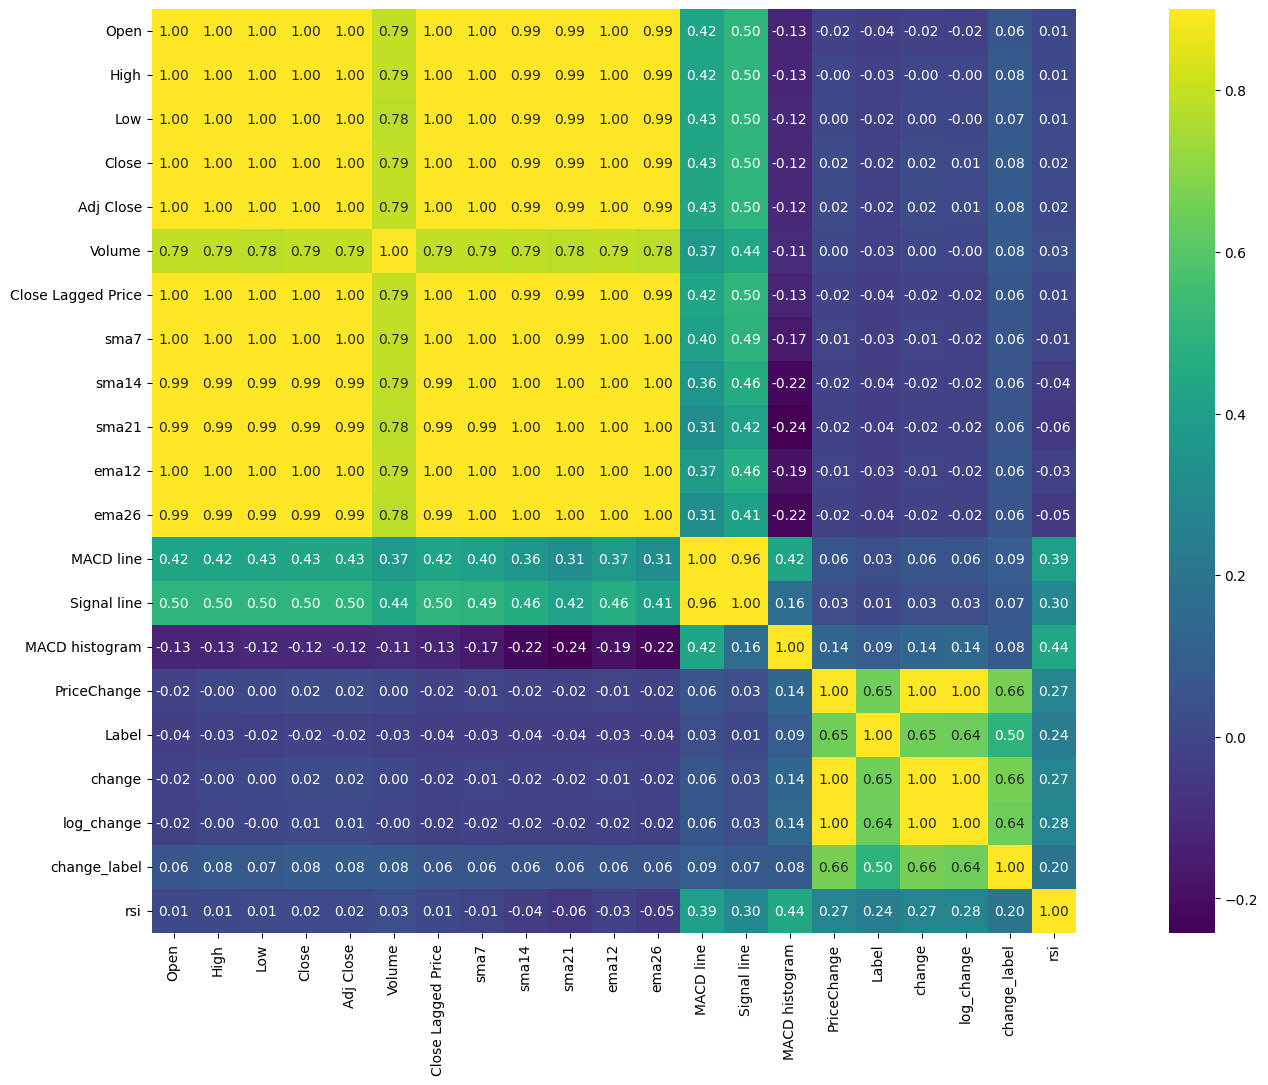

In [176]:
corrmat = price_corr.corr()

ax = plt.subplots(figsize = (24, 12))

sns.heatmap(corrmat, vmax = 0.9, square = True, annot = True, fmt = '0.2f', cmap = 'viridis');

c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Label', ylabel='count'>

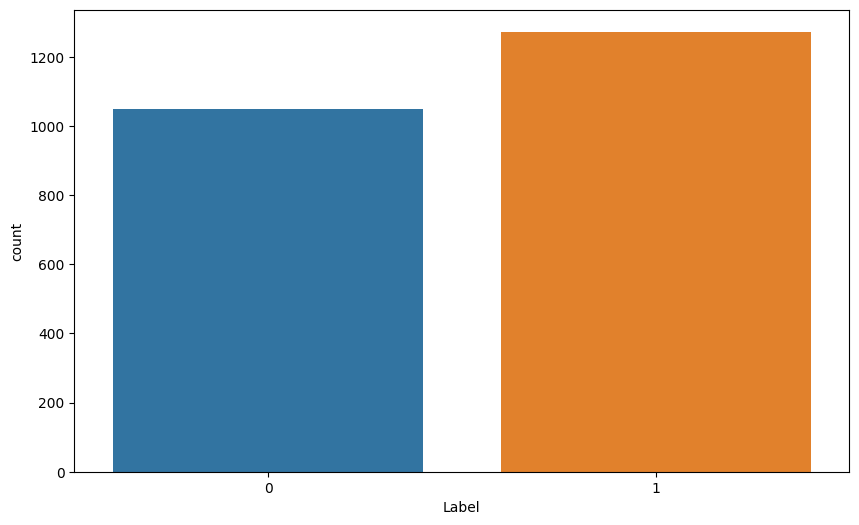

In [209]:
plt.figure(figsize = (10, 6))

sns.countplot(x='Label', data = price)

In [208]:
price['Label'].value_counts()

Label
1    1273
0    1050
Name: count, dtype: int64

In [179]:
# price.skew()

<Figure size 1200x600 with 0 Axes>

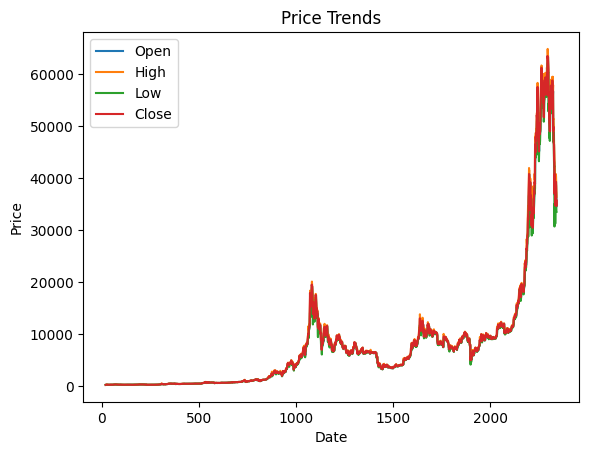

In [180]:
# Plotting Open, High, Low, Close
plt.figure(figsize=(12, 6))
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title('Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

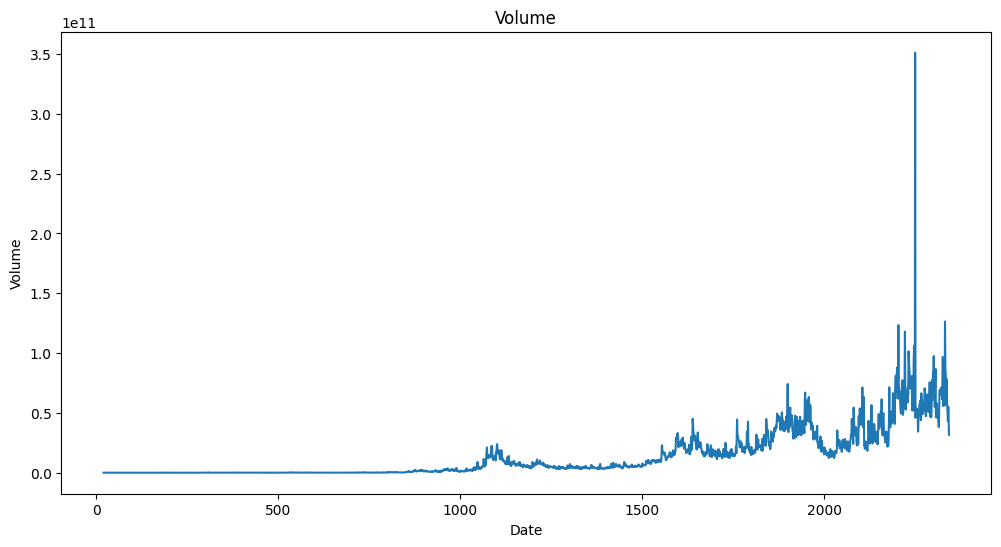

In [181]:
# Plotting Volume
plt.figure(figsize=(12, 6))
price['Volume'].plot()
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

<Figure size 1200x600 with 0 Axes>

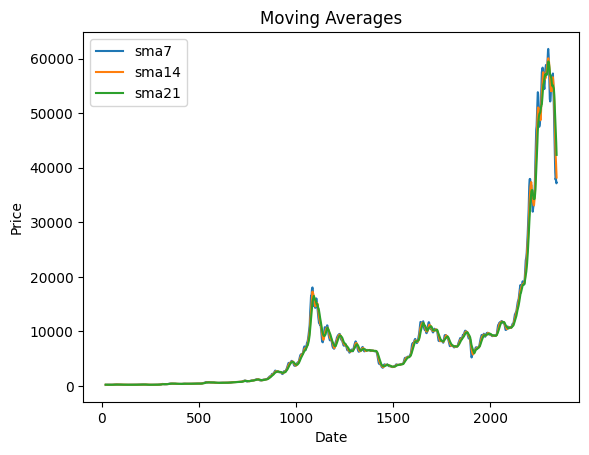

In [182]:
# Plotting Moving Averages
plt.figure(figsize=(12, 6))
price[['sma7', 'sma14', 'sma21']].plot()
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

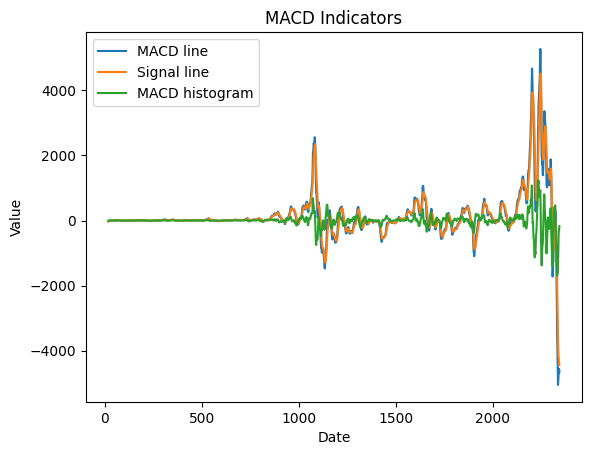

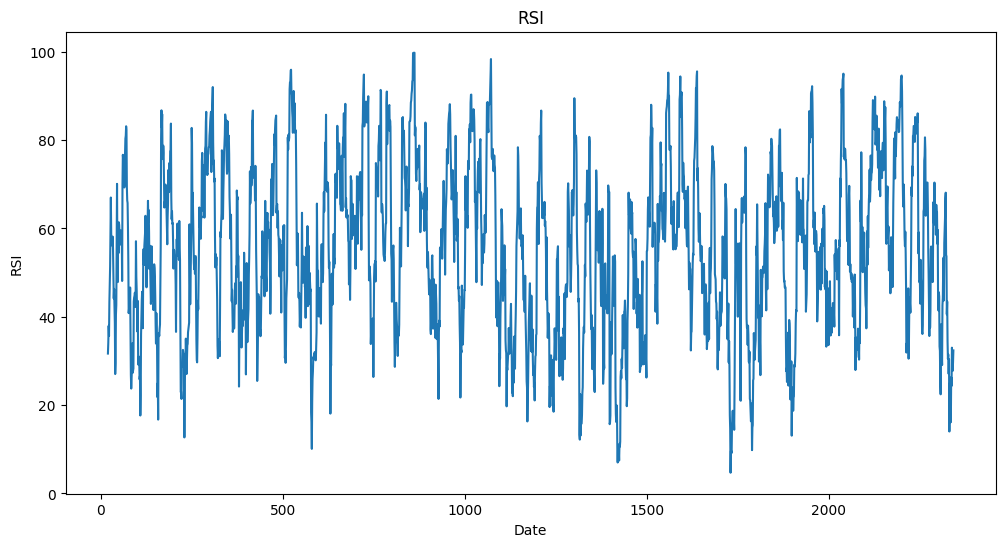

In [183]:
# Plotting MACD Line, Signal Line, MACD Histogram
plt.figure(figsize=(12, 6))
price[['MACD line', 'Signal line', 'MACD histogram']].plot()
plt.title('MACD Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 6))
price['rsi'].plot()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

In [184]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2323 entries, 20 to 2342
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2323 non-null   object 
 1   Open                2323 non-null   float64
 2   High                2323 non-null   float64
 3   Low                 2323 non-null   float64
 4   Close               2323 non-null   float64
 5   Adj Close           2323 non-null   float64
 6   Volume              2323 non-null   int64  
 7   Close Lagged Price  2323 non-null   float64
 8   sma7                2323 non-null   float64
 9   sma14               2323 non-null   float64
 10  sma21               2323 non-null   float64
 11  ema12               2323 non-null   float64
 12  ema26               2323 non-null   float64
 13  MACD line           2323 non-null   float64
 14  Signal line         2323 non-null   float64
 15  MACD histogram      2323 non-null   float64
 16  PriceChang

In [210]:
X = price.drop(['Date', 'change', 'log_change', 'change_label','Label'], axis=1)
Y = price['Label']

In [186]:
X.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Close Lagged Price', 'sma7', 'sma14', 'sma21', 'ema12', 'ema26',
       'MACD line', 'Signal line', 'MACD histogram', 'PriceChange', 'Label',
       'rsi'],
      dtype='object')

In [211]:
# Split the data into training, validation, and testing sets
# First, split into training and temp sets (80% training, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
# Then, split the temp set into validation and testing sets (50% validation, 50% testing)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Train a logistic regression model for price classification

In [212]:
def print_metrics(model_name,y_test,y_pred):
    print(model_name)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
    print('Classification report: ', classification_report(y_test, y_pred))
    df_pred_actual = pd.DataFrame({'predicted': y_pred, 'actual': y_test})
    print(df_pred_actual.head(5))

In [213]:
logistic_model = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [214]:
print("Training_score : " , logistic_model.score(X_train, y_train))

Training_score :  0.5511302475780409


In [225]:
y_pred_logistic = logistic_model.predict(X_test)

In [226]:
print_metrics("Logistic regression",y_test, y_pred_logistic)

Logistic regression
Accuracy:  0.5236051502145923
Precision:  0.5236051502145923
Recall:  1.0
Confusion matrix:  [[  0 111]
 [  0 122]]
Classification report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.52      1.00      0.69       122

    accuracy                           0.52       233
   macro avg       0.26      0.50      0.34       233
weighted avg       0.27      0.52      0.36       233

      predicted  actual
1653          1       0
1987          1       1
1438          1       1
849           1       0
251           1       1


c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

### Naive Bayes

In [193]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

GaussianNB()

In [194]:
y_pred_gnb = gnb_clf.predict(X_test)
print_metrics("GaussianNB",y_test, y_pred_gnb)

GaussianNB
Accuracy:  0.7854077253218884
Precision:  0.0
Recall:  0.0
Confusion matrix:  [[183   1]
 [ 49   0]]
Classification report:                precision    recall  f1-score   support

       False       0.79      0.99      0.88       184
        True       0.00      0.00      0.00        49

    accuracy                           0.79       233
   macro avg       0.39      0.50      0.44       233
weighted avg       0.62      0.79      0.69       233

      predicted  actual
1653      False   False
1987      False   False
1438      False   False
849       False   False
251       False   False


### Support Vector Machines

In [195]:
from sklearn.svm import SVC

svc_clf = SVC()

svc_clf.fit(X_train, y_train)

SVC()

In [196]:
y_pred_svc = svc_clf.predict(X_test)

y_pred_svc[:5]

array([False, False, False, False, False])

In [197]:

print_metrics("SVC",y_test, y_pred_svc)

SVC
Accuracy:  0.7896995708154506
Precision:  0.0
Recall:  0.0
Confusion matrix:  [[184   0]
 [ 49   0]]
Classification report:                precision    recall  f1-score   support

       False       0.79      1.00      0.88       184
        True       0.00      0.00      0.00        49

    accuracy                           0.79       233
   macro avg       0.39      0.50      0.44       233
weighted avg       0.62      0.79      0.70       233

      predicted  actual
1653      False   False
1987      False   False
1438      False   False
849       False   False
251       False   False


c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Random Forest

In [218]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [219]:
y_pred_rf = rf_clf.predict(X_test)

In [221]:
print_metrics("Random forest",y_test, y_pred_rf)

Random forest
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
Confusion matrix:  [[111   0]
 [  0 122]]
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       1.00      1.00      1.00       122

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233

      predicted  actual
1653          0       0
1987          1       1
1438          1       1
849           0       0
251           1       1


### AUC for ROC curves for different algorithmns are obtained.Random Forest has the highest AUC

In [222]:
from sklearn.metrics import auc, roc_curve

In [231]:
def roc_curves(model_name,y_test, y_pred):
    fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred)
    logistic = auc(fpr_logistic, tpr_logistic)
    print('AUC for '+ model_name, logistic)

In [233]:
AUC_logistic = roc_curves("Logistic regression",y_test,y_pred_logistic)

AUC for Logistic regression 0.5


In [234]:
AUC_gnb = roc_curves("Gaussian",y_test,y_pred_gnb)

AUC for Gaussian 0.4954954954954955


In [235]:
AUC_svc = roc_curves("SVC",y_test,y_pred_svc)

AUC for SVC 0.5


In [236]:
AUC_rf = roc_curves("RF",y_test,y_pred_rf)

AUC for RF 1.0


# Process financial article

In [198]:
from joblib import Parallel, delayed
import joblib
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
import re
from nltk.stem import WordNetLemmatizer,PorterStemmer

In [199]:
nltk.download('stopwords')

stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computing\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [200]:
# Import packages
# Default packages
import time
import csv
import os
import json


# Preinstalled packages
import requests
import pandas as pd

# URL of our News API
base_url = 'https://api.newscatcherapi.com/v2/search?lang=en'

# Your API key
X_API_KEY = 'YHBKmAH0DbzXSs_h7be46br_kfw3EhBcqXPtCTSg1Qc'

In [201]:
# Put your API key to headers in order to be authorized to perform a call
headers = {'x-api-key': X_API_KEY}
# Define your desired parameters
# params = [
#     {
#         'q': 'Bitcoin',
#         'lang': 'en',
#         'to_rank': 10000,
#         'topic': "business",
#         'page_size': 100,
#         'page': 1,
#         'from' : "2015/01/01",
#         'to': "2019/12/31"
#     }
# ]

params = [
    {
        'q': 'Bitcoin',
        'lang': 'en',
        'to_rank': 10000,
        'topic': "business",
        'page_size': 100,
        'page': 1
    }
]



In [202]:
# Variable to store all found news articles, mp stands for "multiple queries"
all_news_articles_mp = []

# Infinite loop which ends when all articles are extracted
for separated_param in params:

    print(f'Query in use => {str(separated_param)}')
    
    while True:
        # Wait for 1 second between each call
        time.sleep(1)

        # GET Call from previous section enriched with some logs
        response = requests.get(base_url, headers=headers, params=separated_param)
        results = json.loads(response.text.encode())
        if response.status_code == 200:
            print(f'Done for page number => {separated_param["page"]}')


            # Adding your parameters to each result to be able to explore afterwards
            for i in results['articles']:
                i['used_params'] = str(separated_param)


            # Storing all found articles
            all_news_articles_mp.extend(results['articles'])

            # Ensuring to cover all pages by incrementing "page" value at each iteration
            separated_param['page'] += 1
            if separated_param['page'] > results['total_pages']:
                print("All articles have been extracted")
                break
            else:
                print(f'Proceed extracting page number => {separated_param["page"]}')
        else:
            print(results)
            print(f'ERROR: API call failed for page number => {separated_param["page"]}')
            break

Query in use => {'q': 'Bitcoin', 'lang': 'en', 'to_rank': 10000, 'topic': 'business', 'page_size': 100, 'page': 1}
Done for page number => 1
Proceed extracting page number => 2
Done for page number => 2
All articles have been extracted


In [203]:
print(f'Number of extracted articles => {str(len(all_news_articles_mp))}')

Number of extracted articles => 142


In [204]:
# Define variables
unique_ids = []
all_news_articles = []

# Iterate on each article and check whether we saw this _id before
for article in all_news_articles_mp:
    if article['_id'] not in unique_ids:
        unique_ids.append(article['_id'])
        all_news_articles.append(article)

In [205]:
# Import data into pandas
news_2023 = pd.DataFrame(all_news_articles)

In [206]:
news_2023.head()

,title,author,published_date,published_date_precision,link,clean_url,excerpt,summary,rights,rank,topic,country,language,authors,media,is_opinion,twitter_account,_score,_id,used_params
0,"Education, Human Rights And An Innovation Drai...",Susie Violet Ward,2023-09-03 14:34:06,full,https://www.forbes.com/sites/digital-assets/20...,forbes.com,As nations worldwide grapple with financial an...,Africa's Crucial Bitcoin BTC Testimony\n\nThe ...,Copyright 2023 Forbes Media LLC,49,business,US,en,Susie Violet Ward,https://imageio.forbes.com/specials-images/ima...,False,@forbes,9.721587,c1bb6fb4f7ea1d4e76933115a8185252,"{'q': 'Bitcoin', 'lang': 'en', 'to_rank': 1000..."
1,"A spot bitcoin ETF is much closer to reality, ...",Bob Pisani,2023-08-29 22:15:00,timezone unknown,https://www.cnbc.com/2023/08/29/a-spot-bitcoin...,cnbc.com,"Well, now the SEC is in a real pickle. The U.S...","Well, now the SEC is in a real pickle. \n \nTh...",nbcphiladelphia.com,128,business,US,en,"Bob Pisani,Bob Pisani Cnbc,CNBC",https://media.nbcphiladelphia.com/2023/08/1071...,False,@nbcphiladelphia,9.688607,358436c154af63b0848acfdefb630c3c,"{'q': 'Bitcoin', 'lang': 'en', 'to_rank': 1000..."
2,Bitcoin's Evolution Into A Legitimate Form Of ...,Susie Violet Ward,2023-08-29 14:42:49,full,https://www.forbes.com/sites/digital-assets/20...,forbes.com,Bitcoin's utility as a store of value is under...,"Traditionally, our reliance on government-issu...",Copyright 2023 Forbes Media LLC,49,business,US,en,Susie Violet Ward,https://imageio.forbes.com/specials-images/ima...,False,@DecentraSuze,9.646750,b7061414244da91043b4c58b5f9cd332,"{'q': 'Bitcoin', 'lang': 'en', 'to_rank': 1000..."
3,Bitcoin surges after court clears the way for ...,Matthew Fox,2023-08-29 15:41:11,full,https://markets.businessinsider.com/news/curre...,businessinsider.com,The court ruling could lead to a slew of bitco...,The wait for a \nbitcoin\n ETF could soon be c...,Insider Inc. 2023,106,business,US,en,Matthew Fox,https://i.insider.com/6493236b1465b60019987dc1...,False,@themoneygame,9.642591,dbbcbb9912ec9d315a8c23070d60b523,"{'q': 'Bitcoin', 'lang': 'en', 'to_rank': 1000..."
4,Bitcoin And Human Rights: A Common Ground For ...,Javier Bastardo,2023-08-30 12:27:32,full,https://www.forbes.com/sites/digital-assets/20...,forbes.com,"For HRF, bitcoin is a tool to pursue a politic...",Human rights activism is one of the most dange...,Copyright 2023 Forbes Media LLC,49,business,US,en,Javier Bastardo,https://imageio.forbes.com/specials-images/ima...,False,@forbes,9.587817,76e58a92f84e974b504c5809382c923c,"{'q': 'Bitcoin', 'lang': 'en', 'to_rank': 1000..."


In [207]:
news_2013_2017 = pd.read_csv("../archive/crypto_news_parsed_2013-2017_train.csv")
news_2018 = pd.read_csv("../archive/crypto_news_parsed_2018_validation.csv")


FileNotFoundError: [Errno 2] No such file or directory: '../archive/crypto_news_parsed_2013-2017_train.csv'

In [ ]:
frames = [news_2013_2017,news_2018]
news = pd.concat(frames,ignore_index=True)

In [ ]:
def find_date_from_html(year, html):
    date_regex = str(year) + r'[-/](\d{2})[-/](\d{2})'
    date_matches = re.findall(date_regex,html)
    date_matches = [(int(m),int(d)) for m,d in date_matches if int(m) < 13 and int(d) <= monthrange(int(year), int(m))[1] and int(d) > 0 and int(m) > 0]
    if not date_matches:
        return (None, None)
    return max(set(date_matches), key=date_matches.count)

In [ ]:

date=[]
count=0
for i in range(0,len(news)):
    date.append(find_date_from_html(news['year'][i],news['url'][i]))
    if date[i] == (None,None):
        count+=1

In [ ]:
count

29795

In [ ]:
news.head()

,url,title,text,html,year,author,source
0,https://www.ccn.com/bitcoin-price-update-will-...,Bitcoin Price Update: Will China Lead us Down?,Bitcoin Priced in USD on Mt. GoxAbove is Gox p...,"<figure id=""attachment_4090"" style=""width: 838...",2013,Gordon Hall,altcoin_analysis
1,https://www.ccn.com/key-bitcoin-price-levels-w...,Key Bitcoin Price Levels for Week 51 (15 – 22 ...,"The Bitcoin price up to 2013/12/14, with Fib l...","<figure id=""attachment_3961"" style=""width: 838...",2013,Gordon Hall,altcoin_analysis
2,https://www.ccn.com/national-australia-bank-ci...,"National Australia Bank, Citing Highly Flawed ...",National Australia Bank looms over Melbourne’s...,"<figure id=""attachment_5011"" style=""width: 750...",2013,Gordon Hall,altcoin_analysis
3,https://www.ccn.com/chinese-banking-ban-bitcoi...,Chinese Bitcoin Ban Driven by Chinese Banking...,Recent reports from China indicate there may b...,"<p><span style=""line-height: 1.5em;"">Recent re...",2013,Jonas Borchgrevink,altcoin_analysis
4,https://www.ccn.com/bitcoin-trade-update-opene...,Bitcoin Trade Update: Opened Position,"Opened 1st Bitcoin trade position, price curre...","<figure id=""attachment_4921"" style=""width: 750...",2013,Gordon Hall,altcoin_analysis


In [ ]:
len(news)

39308

In [ ]:
news[["month", "day"]] = news.apply(lambda x: find_date_from_html(x["year"], x["html"]), axis=1, result_type='expand')
news['date'] = pd.to_datetime(news[["year", "month", "day"]], utc=True)
news = news.drop(columns=["year", "month", "day"])
# news = news.set_index("date")
# news.dropna()

In [ ]:
len(news)

39308

In [ ]:
news.dropna()

,url,title,text,html,author,source,date
0,https://www.ccn.com/bitcoin-price-update-will-...,Bitcoin Price Update: Will China Lead us Down?,Bitcoin Priced in USD on Mt. GoxAbove is Gox p...,"<figure id=""attachment_4090"" style=""width: 838...",Gordon Hall,altcoin_analysis,2013-12-16 00:00:00+00:00
1,https://www.ccn.com/key-bitcoin-price-levels-w...,Key Bitcoin Price Levels for Week 51 (15 – 22 ...,"The Bitcoin price up to 2013/12/14, with Fib l...","<figure id=""attachment_3961"" style=""width: 838...",Gordon Hall,altcoin_analysis,2013-12-14 00:00:00+00:00
2,https://www.ccn.com/national-australia-bank-ci...,"National Australia Bank, Citing Highly Flawed ...",National Australia Bank looms over Melbourne’s...,"<figure id=""attachment_5011"" style=""width: 750...",Gordon Hall,altcoin_analysis,2013-12-20 00:00:00+00:00
4,https://www.ccn.com/bitcoin-trade-update-opene...,Bitcoin Trade Update: Opened Position,"Opened 1st Bitcoin trade position, price curre...","<figure id=""attachment_4921"" style=""width: 750...",Gordon Hall,altcoin_analysis,2013-12-21 00:00:00+00:00
5,https://www.ccn.com/key-bitcoin-price-levels-w...,Key Bitcoin Price Levels for Week 52 (22 – 28 ...,"Gox Bitcoin Price, Volume, Fib Levels, trendli...","<figure id=""attachment_4520"" style=""width: 192...",Gordon Hall,altcoin_analysis,2013-12-05 00:00:00+00:00
...,...,...,...,...,...,...,...
39262,https://cointelegraph.com/news/indie-game-deli...,Indie Game Delisted From Steam Marketplace for...,Valve Corporation has removed a game from its ...,"<p dir=""ltr"">Valve Corporation has removed a g...",Ana Alexandre,scam_news,2018-07-30 00:00:00+00:00
39279,https://cointelegraph.com/news/korean-crypto-e...,Korean Crypto Exchange Execs Detained On Fraud...,CoinNest co-founder and chief executive Kim Ik...,"<p dir=""ltr""><a href=""https://www.coinnest.co....",Marie Huillet,scam_news,2018-01-23 00:00:00+00:00
39291,https://cointelegraph.com/news/steve-wozniak-l...,Steve Wozniak ‘Loses 7 BTC’ In Unlikely Credit...,Apple co-founder Steve Wozniak allegedly lost ...,"<p dir=""ltr"">Apple co-founder Steve Wozniak al...",William Suberg,scam_news,2018-02-26 00:00:00+00:00
39298,https://cointelegraph.com/news/opera-browser-a...,"Opera Browser Addresses Cryptojacking, Adds An...","Opera, a web browser that has since December i...","<p dir=""ltr"">Opera, a web browser that has sin...",Molly Jane Zuckerman,scam_news,2018-01-22 00:00:00+00:00


In [ ]:
len(news)

39308

In [ ]:
news = news.dropna(subset=['date'])


In [ ]:
len(news)

15350

In [ ]:
# pd.set_option('display.max_rows', None)

In [ ]:
# # Set the maximum number of rows to display
# pd.set_option('display.max_rows', None)
# # Reset display options to default
# pd.reset_option('display.max_rows')


In [ ]:
news['date']=news.date.apply (lambda x : str(x)[:10])

In [ ]:
print(news['date'])

0        2013-12-16
1        2013-12-14
2        2013-12-20
4        2013-12-21
5        2013-12-05
            ...    
39262    2018-07-30
39279    2018-01-23
39291    2018-02-26
39298    2018-01-22
39299    2018-05-11
Name: date, Length: 15350, dtype: object


In [ ]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
news['title']=news['title'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
news['title']=news['title'].apply(lambda x:remove_html(x))

In [ ]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
news['title']=news['title'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
news['title']=news['title'].apply(lambda x:remove_num(x))

In [ ]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
news['title']=news['title'].apply(lambda x:punct_remove(x))



def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
news['title']=news['title'].apply(lambda x:remove_stopwords(x))

In [ ]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
news['title']=news['title'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
news['title']=news['title'].apply(lambda x:remove_hash(x))

In [ ]:
#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
def stemming(text):
    ps = PorterStemmer()
    
    return" ".join([ps.stem(word) for word in str(text).split()])
    
def lemmatizing(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    
    return" ".join([wordnet_lemmatizer.lemmatize(word) for word in str(text).split()])
news['title']=news['title'].apply(lambda x:remove_space(x))

In [ ]:
from collections import Counter
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in news.title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
split_it = comment_words.split()
Counter = Counter(split_it)
number=20
most_occur = Counter.most_common(number)
most_occur

[('bitcoin', 6996),
 ('price', 5112),
 ('analysis', 3513),
 ('technical', 1946),
 ('ethereum', 1446),
 ('watch', 1200),
 ('blockchain', 1169),
 ('crypto', 885),
 ('cryptocurrency', 698),
 ('new', 595),
 ('btc', 563),
 ('ethusd', 537),
 ('trading', 498),
 ('exchange', 491),
 ('cash', 481),
 ('litecoin', 470),
 ('ripple', 414),
 ('tech', 406),
 ('weekly', 381),
 ('bank', 373)]

<Axes: xlabel='Word'>

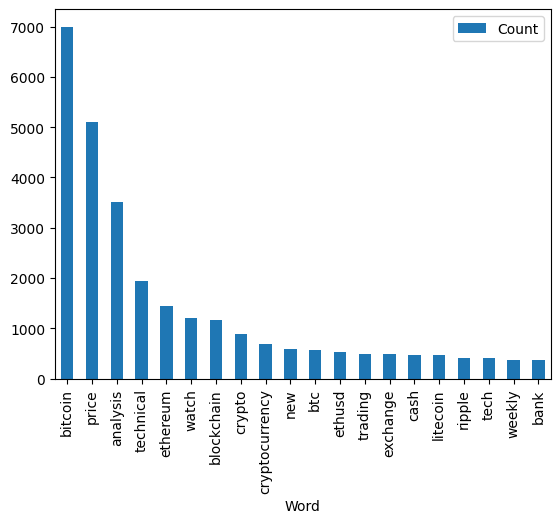

In [ ]:
dfm = pd.DataFrame(most_occur, columns = ['Word', 'Count'])
dfm.plot.bar(x='Word',y='Count')

In [ ]:
news['title']=news['title'].apply(lambda x:stemming(x))

In [ ]:
news

,url,title,text,html,author,source,date
0,https://www.ccn.com/bitcoin-price-update-will-...,bitcoin price updat china lead us,Bitcoin Priced in USD on Mt. GoxAbove is Gox p...,"<figure id=""attachment_4090"" style=""width: 838...",Gordon Hall,altcoin_analysis,2013-12-16
1,https://www.ccn.com/key-bitcoin-price-levels-w...,key bitcoin price level week dec,"The Bitcoin price up to 2013/12/14, with Fib l...","<figure id=""attachment_3961"" style=""width: 838...",Gordon Hall,altcoin_analysis,2013-12-14
2,https://www.ccn.com/national-australia-bank-ci...,nation australia bank cite highli flaw data ca...,National Australia Bank looms over Melbourne’s...,"<figure id=""attachment_5011"" style=""width: 750...",Gordon Hall,altcoin_analysis,2013-12-20
4,https://www.ccn.com/bitcoin-trade-update-opene...,bitcoin trade updat open posit,"Opened 1st Bitcoin trade position, price curre...","<figure id=""attachment_4921"" style=""width: 750...",Gordon Hall,altcoin_analysis,2013-12-21
5,https://www.ccn.com/key-bitcoin-price-levels-w...,key bitcoin price level week dec trade plan,"Gox Bitcoin Price, Volume, Fib Levels, trendli...","<figure id=""attachment_4520"" style=""width: 192...",Gordon Hall,altcoin_analysis,2013-12-05
...,...,...,...,...,...,...,...
39262,https://cointelegraph.com/news/indie-game-deli...,indi game delist steam marketplac alleg crypto...,Valve Corporation has removed a game from its ...,"<p dir=""ltr"">Valve Corporation has removed a g...",Ana Alexandre,scam_news,2018-07-30
39279,https://cointelegraph.com/news/korean-crypto-e...,korean crypto exchang exec detain fraud embezz...,CoinNest co-founder and chief executive Kim Ik...,"<p dir=""ltr""><a href=""https://www.coinnest.co....",Marie Huillet,scam_news,2018-01-23
39291,https://cointelegraph.com/news/steve-wozniak-l...,steve wozniak lose btc unlik credit card fraud,Apple co-founder Steve Wozniak allegedly lost ...,"<p dir=""ltr"">Apple co-founder Steve Wozniak al...",William Suberg,scam_news,2018-02-26
39298,https://cointelegraph.com/news/opera-browser-a...,opera browser address cryptojack add anticrypt...,"Opera, a web browser that has since December i...","<p dir=""ltr"">Opera, a web browser that has sin...",Molly Jane Zuckerman,scam_news,2018-01-22


In [ ]:
news = news.groupby('date')['title'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
len(news)

1735

In [ ]:
news.head()

,date,title
0,2013-01-01,happen us regul bitcoin meet bitcoin exchang b...
1,2013-01-02,vault satoshi expand canadian bitcoin exchang ...
2,2013-01-22,gambl bitcoin block chain
3,2013-01-26,bitmark want move money bitcoin incasino gambl
4,2013-02-01,bitcoin solut startup intern bank issu


In [ ]:
news.rename(columns={"date": "Date"}, inplace=True)
price.rename(columns={"date": "Date"}, inplace=True)

In [ ]:
news_price = news.merge(price, how='outer', on=['Date'])

In [ ]:
news_price = news_price.dropna()

In [ ]:
len(news_price)

1257

# Process tweets

In [ ]:
tweets_2015 = pd.read_csv('../archive/data/tweets/combined_tweets_2015_labeled.csv')
tweets_2016 = pd.read_csv('../archive/data/tweets/combined_tweets_2016_labeled.csv')
tweets_2017 = pd.read_csv('../archive/data/tweets/combined_tweets_2017_labeled.csv')
tweets_2018 = pd.read_csv('../archive/data/tweets/combined_tweets_2018_labeled.csv')
tweets_2019 = pd.read_csv('../archive/data/tweets/combined_tweets_2019_apr_dec_labeled.csv')
tweets_2020 = pd.read_csv('../archive/data/tweets/combined_tweets_2020_labeled.csv')
tweets_2021 = pd.read_csv('../archive/data/tweets/combined_tweets_2021_jan_may_labeled.csv')



In [ ]:
frames = [tweets_2015,tweets_2016,tweets_2017,tweets_2018,tweets_2019,tweets_2020,tweets_2021]
tweets = pd.concat(frames,ignore_index=True)

In [ ]:
tweets.rename(columns={"date": "Date"}, inplace=True)

In [ ]:
tweets

,Unnamed: 0,Date,text_split,label_up5,label_up2,label_down5,label_down2
0,0,2015-01-01,blocked me thats my achievement still like bit...,False,False,False,False
1,1,2015-01-01,accept here is bitcoin tip via claim it here c...,False,False,False,False
2,2,2015-01-01,btc bitcoin current price btc bitcoin parking ...,False,False,False,False
3,3,2015-01-01,revolution don miss out your bitcoin tip about...,False,False,False,False
4,4,2015-01-01,cap billion based on bitcoin informative my da...,False,False,False,False
...,...,...,...,...,...,...,...
342057,31805,2021-05-31,bitcoin claim free bitcoin bitcoin price sugge...,True,True,False,True
342058,31806,2021-05-31,het roulette het is wat of twitter deal gift s...,True,True,False,True
342059,31807,2021-05-31,longer it stays in this range it will be it go...,True,True,False,True
342060,31808,2021-05-31,en el video para el de media el de en ya para ...,True,True,False,True


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
sentence = tweets['text_split'].values
label = tweets['label_down2'].map({True: 1, False: 0})

In [ ]:
label

0         0
1         0
2         0
3         0
4         0
         ..
342057    1
342058    1
342059    1
342060    1
342061    1
Name: label_down2, Length: 342062, dtype: int64

In [ ]:
sentence_train,sentence_test, label_train,label_test = train_test_split(sentence, label,test_size=0.25, random_state=1000)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer  = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentence_train)


In [ ]:
xcnn_train = tokenizer.texts_to_sequences(sentence_train)
xcnn_test = tokenizer.texts_to_sequences(sentence_test)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D

In [ ]:
maxlen = 200
xcnn_train = pad_sequences(xcnn_train,padding='post', maxlen=maxlen)

xcnn_test = pad_sequences(xcnn_test, padding='post',maxlen=maxlen)

In [ ]:
embedding_dim = 200
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length=maxlen))
model.add(Conv1D(128,5,activation='relu'))
model.add(MaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 200)          7069800   
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 128)          128128    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 98, 128)          0         
 1D)                                                             
                                                                 
 dense_4 (Dense)             (None, 98, 10)            1290      
                                                                 
 dense_5 (Dense)             (None, 98, 1)             11        
                                                                 
Total params: 7,199,229
Trainable params: 7,199,229
Non-trainable params: 0
____________________________________________

In [ ]:
model.fit(xcnn_train, label_train, epochs=2, verbose=True, validation_data=(xcnn_test,label_test),batch_size=10)

Epoch 1/2
25655/25655 [==============================] - 2741s 106ms/step - loss: 0.6902 - accuracy: 0.5387 - val_loss: 0.6899 - val_accuracy: 0.5400
Epoch 2/2
 2525/25655 [=>............................] - ETA: 39:01 - loss: 0.6898 - accuracy: 0.5412

In [ ]:
print(vocab_size)
print(sentence_train[1])
print(xcnn_train[1])

35349
para el nice more that would adopt bitcoin in the future pro tip find top copy their automatically bitcoin via crypto bitcoin is bitcoin currency though seriously coin btc good article on bitcoin and view on its common iceland big bitcoin with over in stolen mining you don have to literally say buy bitcoin to say buy bitcoin all the big offering bitcoin related assets say that they are in the early of offering it to their this that they have bought of bitcoin in this dip and will buy more bitcoin dealer on money without bond money is freedom invest and make profit in my company brokage platform now for more serious minded invest wealth business cash rich entrepreneur finance profit debt bitcoin the crypto to as ether founder growth is near ceiling bitcoin as sec two linked to crypto how long will it be before all have style listening to think people choose to invite it into their ai advertising bitcoin fashion marketing crypto entrepreneur quote bitcoin bin den bitcoin bitcoin ca

In [ ]:
tokenizer

In [ ]:
len(tweets['text_split'][3])

1099

In [ ]:
tweets = tweets.groupby('Date')['text_split'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
# tweets = tweets.drop(columns=['date', 'label_up5','label_up2','label_down5','label_down2'])

In [ ]:
tweets.shape

(2247, 2)

In [ ]:
tweets

,Date,text_split
0,2015-01-01,blocked me thats my achievement still like bit...
1,2015-01-02,bitcoin my brother and have just our first me ...
2,2015-01-03,bitcoin btc new post cryptocurrency trading ne...
3,2015-01-04,in the last there were exchange pair yielding ...
4,2015-01-05,can wait to get my tax refund and buy bitcoin ...
...,...,...
2242,2021-05-27,bitcoin cryptocurrency money the central histo...
2243,2021-05-28,what to do when bitcoin price crash bitcoin to...
2244,2021-05-29,great project and hope it will achieve lots of...
2245,2021-05-30,rager was do that too but like it will take of...


In [ ]:

# tweets['Date']=tweets.Date.apply (lambda x : str(x)[:10])

In [ ]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [ ]:
price['Date'] = pd.to_datetime(price['Date'])

In [ ]:
price_tweets = tweets.merge(price, how='outer', on=['Date'])

In [ ]:
price_tweets.head()

,Date,text_split,Open,High,Low,Close,Adj Close,Volume,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,change,log_change,change_label,rsi
0,2015-01-01,blocked me thats my achievement still like bit...,320.434998,320.434998,314.002991,314.248993,314.248993,8036550.0,NaN,NaN,NaN,319.278532,319.752697,-0.474165,-0.094833,-0.379332,-0.018564,-0.018738,False,NaN
1,2015-01-02,bitcoin my brother and have just our first me ...,314.079010,315.838989,313.565002,315.032013,315.032013,7860650.0,NaN,NaN,NaN,318.625221,319.403017,-0.777796,-0.231426,-0.546370,0.002492,0.002489,True,NaN
2,2015-01-03,bitcoin btc new post cryptocurrency trading ne...,314.846008,315.149994,281.082001,281.082001,281.082001,33054400.0,NaN,NaN,NaN,312.849341,316.564423,-3.715082,-0.928157,-2.786925,-0.107767,-0.114028,False,NaN
3,2015-01-04,in the last there were exchange pair yielding ...,281.145996,287.230011,257.612000,264.195007,264.195007,55629100.0,NaN,NaN,NaN,305.364059,312.685207,-7.321148,-2.206755,-5.114393,-0.060079,-0.061959,False,NaN
4,2015-01-05,can wait to get my tax refund and buy bitcoin ...,265.084015,278.341003,265.084015,274.473999,274.473999,43962800.0,NaN,NaN,NaN,300.611742,309.854747,-9.243005,-3.614005,-5.629000,0.038907,0.038169,True,NaN


In [ ]:
price_tweets.shape

(2344, 20)

In [ ]:
price_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2343
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2344 non-null   datetime64[ns]
 1   text_split      2247 non-null   object        
 2   Open            2343 non-null   float64       
 3   High            2343 non-null   float64       
 4   Low             2343 non-null   float64       
 5   Close           2343 non-null   float64       
 6   Adj Close       2343 non-null   float64       
 7   Volume          2343 non-null   float64       
 8   sma7            2337 non-null   float64       
 9   sma14           2330 non-null   float64       
 10  sma21           2323 non-null   float64       
 11  ema12           2343 non-null   float64       
 12  ema26           2343 non-null   float64       
 13  MACD line       2343 non-null   float64       
 14  Signal line     2343 non-null   float64       
 15  MACD

# Process news article

In [ ]:
news = pd.read_csv('../archive/data/cryptonews_processed_2013_2022.csv')

In [ ]:
news.shape

(28100, 3)

In [ ]:
news.rename(columns={"date": "Date"}, inplace=True)

In [ ]:
news['Date']=news.Date.apply (lambda x : str(x)[:10])

In [ ]:
news= news.sort_values('Date',ascending=True)

In [ ]:
news = news.groupby('Date')['title'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
news['Date'] = pd.to_datetime(news['Date'])

In [ ]:
news.tail()

,Date,title
2104,2022-11-11,bitcoin altcoin cryptolink stock correct sharp...
2105,2022-11-12,meltdown ftx consecut crash crypto market trig...
2106,2022-11-13,w dubai palm three subway outlet germani lates...
2107,2022-11-14,lin li compani founder agre lend million new h...
2108,2022-11-15,hbit seek legal advic recov digit asset questi...


In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2109 non-null   datetime64[ns]
 1   title   2109 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 33.1+ KB


In [ ]:
news.head()

,Date,title
0,2013-01-01,bitcoin exchange btc china temporarily halts t...
1,2013-01-02,vault satoshi expands canadian bitcoin exchang...
2,2013-01-22,gambling bitcoin block chain
3,2013-01-26,bitmarkers wants move money bitcoin incasino g...
4,2013-02-01,bitcoin solution startups international bankin...


In [ ]:
price.shape

(3178, 21)

In [ ]:
price['Date'] = pd.to_datetime(price['Date'])

In [ ]:
price_news = news.merge(price, how='outer', on=['Date'])

In [ ]:
price_news.shape

(3175, 20)

In [ ]:
price_news = price_news.dropna()

In [ ]:
price_news.shape

(1258, 20)

In [ ]:
price_news.tail(1)

,Date,title,index,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price,...,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,change,log_change,change_label,rsi
2108,2022-11-15,hbit seek legal advic recov digit asset questi...,2981.0,16617.484375,17051.962891,16542.550781,16884.613281,16884.613281,3.659944e+10,16618.199219,...,19243.521531,17832.666267,18701.799922,-869.133655,-492.353627,-376.780028,0.016031,0.015904,True,32.557499


## Word embeddings

#### Now that we have our dataset, let's get the word embedding for the news articles

In [ ]:
%pip install transformers torch


[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from transformers import AutoModel, AutoTokenizer

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
def processEmbeddings(text):
    tokens = tokenizer.tokenize(text)

    # Set the maximum segment length and overlap
    max_segment_length = 200
    overlap = 50

    # Initialize lists to store embeddings and segment tokens
    embeddings_list = []
    segment_tokens_list = []

    # Slide a window over the tokens and process each segment
    for start in range(0, len(tokens), max_segment_length - overlap):
        end = start + max_segment_length
        segment_tokens = tokens[start:end]

        # Convert segment tokens back to text and encode
        segment_text = tokenizer.convert_tokens_to_string(segment_tokens)
        inputs = tokenizer(segment_text, return_tensors="pt", padding=True, truncation=True)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :]

        embeddings_list.append(embeddings)
        segment_tokens_list.append(segment_tokens)

    # Combine embeddings and segment tokens for the entire text
    all_embeddings = torch.cat(embeddings_list, dim=0)
    # all_segment_tokens = sum(segment_tokens_list, [])
    
    return all_embeddings


In [ ]:
price_tweets['text_embeddings'] = price_tweets['text_split'].apply(processEmbeddings)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
price_tweets.iloc[1720]['text_embeddings'].shape[0]

768

In [ ]:
embedding_dim = price_tweets.iloc[1720]['text_embeddings'].shape[0]

In [ ]:
### without split the length of the headline we got this error => RuntimeError: The size of tensor a (1102) must match the size of tensor b (512) at non-singleton dimension 1

In [ ]:
price_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2343
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2344 non-null   datetime64[ns]
 1   text_split       2247 non-null   object        
 2   Open             2343 non-null   float64       
 3   High             2343 non-null   float64       
 4   Low              2343 non-null   float64       
 5   Close            2343 non-null   float64       
 6   Adj Close        2343 non-null   float64       
 7   Volume           2343 non-null   float64       
 8   sma7             2337 non-null   float64       
 9   sma14            2330 non-null   float64       
 10  sma21            2323 non-null   float64       
 11  ema12            2343 non-null   float64       
 12  ema26            2343 non-null   float64       
 13  MACD line        2343 non-null   float64       
 14  Signal line      2343 non-null   float64

In [ ]:
price_tweets = price_tweets.dropna()

In [ ]:
price_tweets.shape

(2227, 21)

In [ ]:
price_tweets['change_label'].unique()

array([False, True], dtype=object)

In [ ]:
# Replace True with 1 and False with 0
price_tweets['change_label'] = price_tweets['change_label'].map({True: 1, False: 0})

C:\Users\HP\AppData\Local\Temp\ipykernel_15080\3128454574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_tweets['change_label'] = price_tweets['change_label'].map({True: 1, False: 0})


In [ ]:
price_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2227 entries, 19 to 2245
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2227 non-null   datetime64[ns]
 1   text_split       2227 non-null   object        
 2   Open             2227 non-null   float64       
 3   High             2227 non-null   float64       
 4   Low              2227 non-null   float64       
 5   Close            2227 non-null   float64       
 6   Adj Close        2227 non-null   float64       
 7   Volume           2227 non-null   float64       
 8   sma7             2227 non-null   float64       
 9   sma14            2227 non-null   float64       
 10  sma21            2227 non-null   float64       
 11  ema12            2227 non-null   float64       
 12  ema26            2227 non-null   float64       
 13  MACD line        2227 non-null   float64       
 14  Signal line      2227 non-null   float6

### Build the architecture

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D

In [ ]:
features = price_tweets[['text_embeddings']]
target = price_tweets['change_label']

In [ ]:
target

19      0
20      1
21      1
22      0
23      1
       ..
2241    1
2242    0
2243    0
2244    0
2245    1
Name: change_label, Length: 2227, dtype: int64

In [ ]:
# features = price_tweets.drop(['change_label', 'Date'], axis=1)  # Adjust columns as needed
# target = price_tweets['change_label']

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1726 entries, 383 to 2108
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               1726 non-null   float64
 1   Open                1726 non-null   float64
 2   High                1726 non-null   float64
 3   Low                 1726 non-null   float64
 4   Close               1726 non-null   float64
 5   Adj Close           1726 non-null   float64
 6   Volume              1726 non-null   float64
 7   Close Lagged Price  1726 non-null   float64
 8   sma7                1726 non-null   float64
 9   sma14               1726 non-null   float64
 10  sma21               1726 non-null   float64
 11  ema12               1726 non-null   float64
 12  ema26               1726 non-null   float64
 13  MACD line           1726 non-null   float64
 14  Signal line         1726 non-null   float64
 15  MACD histogram      1726 non-null   float64
 16  chan

In [ ]:
# Split the data into training, validation, and testing sets
# First, split into training and temp sets (80% training, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.2, random_state=42)

# Then, split the temp set into validation and testing sets (50% validation, 50% testing)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Normalize numerical features for each set
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.drop('text_embeddings', axis=1))
# X_val_scaled = scaler.transform(X_val.drop('text_embeddings', axis=1))
# X_test_scaled = scaler.transform(X_test.drop('text_embeddings', axis=1))


### Build CNN model

In [ ]:
def cnn(embedding_dim):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(embedding_dim, 1)))
    model.add(MaxPooling1D(2))
    # model.add(Conv1D(128, 3, activation='relu'))
    # model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # model.add(Conv1D(filters=16, kernel_size=(3,3), activation="relu",input_shape=(embedding_dim,)))

    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
    
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
    
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Flatten())

    # model.add(Dense(64,activation='relu'))

    # model.add(Dense(1,activation='sigmoid'))

    # model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [ ]:
embedding_dim = X_train.iloc[0]['text_embeddings'].shape[0]

In [ ]:
model = cnn(embedding_dim)

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 766, 64)           256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 383, 64)          0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 24512)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               3137664   
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,138,049
Trainable params: 3,138,049
Non-trainable params: 0
____________________________________________

In [ ]:
embedding_dim = X_train.iloc[0]['text_embeddings'].shape[0]

In [ ]:
# Build the LSTM model for text embeddings
embedding_dim = X_train.iloc[0]['text_embeddings'].shape[0]
text_input = Input(shape=(embedding_dim,), name='text_input')
text_lstm = Dense(64, activation='relu')(text_input)

In [ ]:
# Build the LSTM model for numerical features
num_features_input = Input(shape=(X_train_scaled.shape[1],), name='num_features_input')
num_lstm = Dense(64, activation='relu')(num_features_input)

In [ ]:
# Combine the outputs of both LSTM models
concatenated = concatenate([text_lstm, num_lstm])

In [ ]:
# Build the final prediction layer
output = Dense(1, activation='sigmoid')(concatenated)

In [ ]:
# Create the multi-modal model
model = Model(inputs=[text_input, num_features_input], outputs=output)

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
data = features['text_embeddings']

In [ ]:
target.info()

<class 'pandas.core.series.Series'>
Int64Index: 2227 entries, 19 to 2245
Series name: change_label
Non-Null Count  Dtype
--------------  -----
2227 non-null   int64
dtypes: int64(1)
memory usage: 34.8 KB


In [ ]:
import tensorflow as tf


In [ ]:
embeddings_tensor = tf.convert_to_tensor(features['text_embeddings'].values)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [ ]:
model.fit(data, np.array(target),validation_split=0.4, epochs=3)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [ ]:
# Train the model
model.fit([np.array(X_train['text_embeddings']), X_train_scaled], y_train,
          epochs=10, batch_size=32, validation_data=([np.array(X_test['text_embeddings'].tolist()), X_test], y_test))


ValueError: Data cardinality is ambiguous:
  x sizes: 1781, 1380
  y sizes: 1781
Make sure all arrays contain the same number of samples.

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate([np.array(X_test['text_embeddings'].tolist()), X_test_scaled], y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

6/6 [==============================] - 0s 4ms/step - loss: 0.1413 - accuracy: 0.9653
Loss: 0.1412552446126938, Accuracy: 0.9653179049491882
